# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import re
from nltk.stem import WordNetLemmatizer
from sklearn.multioutput import MultiOutputClassifier

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.ensemble import RandomForestClassifier



In [2]:
!pip install ntlk
import nltk
nltk.download('punkt')
nltk.download('wordnet')

  Could not find a version that satisfies the requirement ntlk (from versions: )
No matching distribution found for ntlk
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,classification_report

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline,FeatureUnion
import pickle

In [5]:
engine = create_engine('sqlite:///InsertDatabaseName.db')
df=pd.read_sql_table('InsertTableName',con=engine)

In [6]:
df.columns

Index(['id', 'message', 'original', 'genre', 'related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

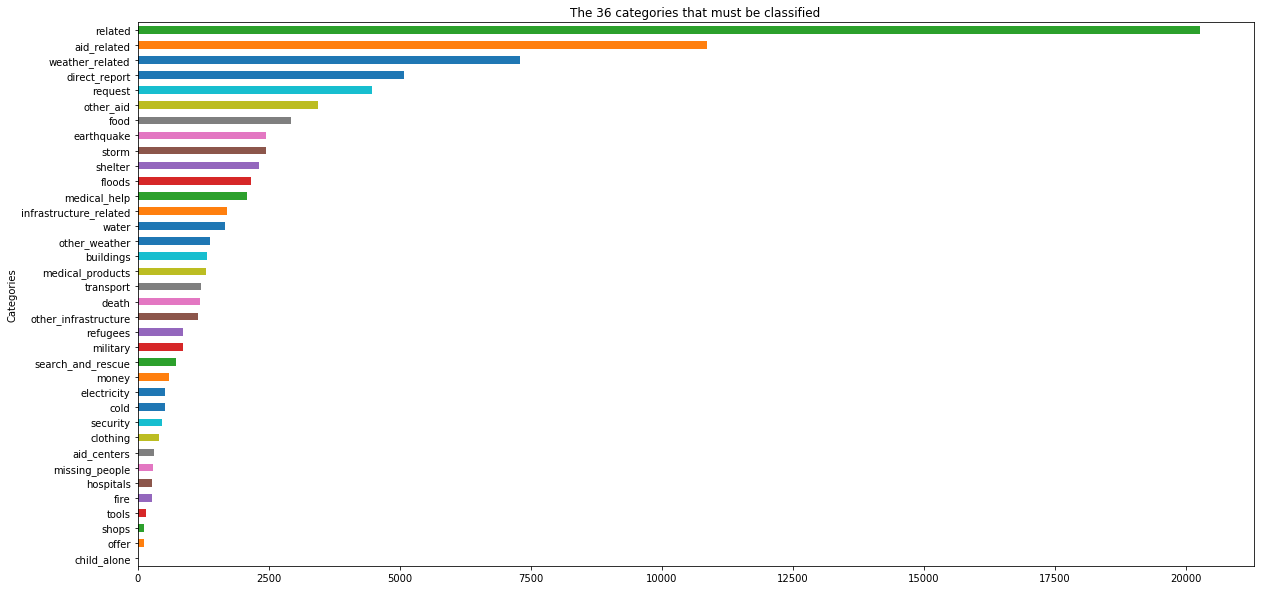

In [21]:
import matplotlib.pyplot as plt
cats=df.columns[4:]
plt.figure(figsize=(20,10))
df[cats].sum().sort_values().plot.barh()
plt.title('The 36 categories that must be classified')
plt.ylabel('Categories')
plt

In [22]:
cats

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

In [7]:

X = df['message']
Y = df[df.columns[4:]]

### 2. Write a tokenization function to process your text data

In [8]:
def tokenize(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_url=re.findall(url_regex,text)
    for url in detected_url:
        text=text.replace(url,"urlplaceholder")
    text=re.sub(r"[^a-zA-Z0-9]"," ",text)
    text=word_tokenize(text)
    lemmatizer=WordNetLemmatizer()
    clean_tokens=[]
    for tok in text:
        token=lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(token)
    return clean_tokens
    
    
        

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [9]:
pipeline = Pipeline([('vect',CountVectorizer(tokenizer=tokenize)),
                    ('tfidf',TfidfTransformer()),
                     ('clf',MultiOutputClassifier(RandomForestClassifier()))])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=42)
pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [11]:
def get_results(y_test, y_pred):
    results = pd.DataFrame(columns=['Category', 'f_score', 'precision', 'recall'])
    num = 0
    for cat in y_test.columns:
        precision, recall, f_score, support = precision_recall_fscore_support(y_test[cat], y_pred[:,num], average='weighted')
        results.set_value(num+1, 'Category', cat)
        results.set_value(num+1, 'f_score', f_score)
        results.set_value(num+1, 'precision', precision)
        results.set_value(num+1, 'recall', recall)
        num += 1
    print('Aggregated f_score:', results['f_score'].mean())
    print('Aggregated precision:', results['precision'].mean())
    print('Aggregated recall:', results['recall'].mean())
    return results

In [12]:
results = get_results(y_test, y_pred)
results

Aggregated f_score: 0.928584179892
Aggregated precision: 0.932071687817
Aggregated recall: 0.942308344353


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sample

,Category,f_score,precision,recall
1,related,0.763445,0.76647,0.787
2,request,0.867572,0.878919,0.884498
3,offer,0.992454,0.989955,0.994965
4,aid_related,0.720572,0.735035,0.732225
5,medical_help,0.894459,0.896878,0.920507
6,medical_products,0.933309,0.942022,0.951175
7,search_and_rescue,0.968006,0.972499,0.977113
8,security,0.97375,0.970957,0.982148
9,military,0.955489,0.950745,0.968721
10,child_alone,1,1,1


In [13]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=<function tokenize at 0x7f2347f4ed08>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=None,

### 6. Improve your model
Use grid search to find better parameters. 

In [14]:
parameters = {'tfidf__smooth_idf':[True,False]}
cv = GridSearchCV(pipeline,n_jobs=-1,param_grid=parameters)

In [15]:
cv.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'tfidf__smooth_idf': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Aggregated f_score: 0.929381675809
Aggregated precision: 0.933436848243
Aggregated recall: 0.942863560845


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sample

,Category,f_score,precision,recall
1,related,0.75749,0.75538,0.778303
2,request,0.860351,0.878197,0.881141
3,offer,0.992454,0.989955,0.994965
4,aid_related,0.72618,0.739531,0.736955
5,medical_help,0.897685,0.902398,0.922338
6,medical_products,0.933107,0.940434,0.95087
7,search_and_rescue,0.96639,0.967,0.976045
8,security,0.973378,0.96491,0.981996
9,military,0.959894,0.959664,0.970095
10,child_alone,1,1,1


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [22]:
y_pred1=cv.predict(X_test)
result2=get_results(y_test,y_pred1)
result2

Aggregated f_score: 0.929381675809
Aggregated precision: 0.933436848243
Aggregated recall: 0.942863560845


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sample

,Category,f_score,precision,recall
1,related,0.75749,0.75538,0.778303
2,request,0.860351,0.878197,0.881141
3,offer,0.992454,0.989955,0.994965
4,aid_related,0.72618,0.739531,0.736955
5,medical_help,0.897685,0.902398,0.922338
6,medical_products,0.933107,0.940434,0.95087
7,search_and_rescue,0.96639,0.967,0.976045
8,security,0.973378,0.96491,0.981996
9,military,0.959894,0.959664,0.970095
10,child_alone,1,1,1


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [24]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    """
    Starting Verb Extractor class
    
    This class extract the starting verb of a sentence,
    creating a new feature for the ML classifier
    """

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    # Given it is a tranformer we can return the self 
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [29]:
pipeline2 = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('count_', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb_transformer', StartingVerbExtractor())
        ])),

        ('classifier', MultiOutputClassifier(DecisionTreeClassifier()))
    ])

In [30]:

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
results = get_results(y_test, y_pred)
results

Aggregated f_score: 0.929853567997
Aggregated precision: 0.933286160039
Aggregated recall: 0.943283151934


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sample

,Category,f_score,precision,recall
1,related,0.772087,0.773252,0.792646
2,request,0.867204,0.880699,0.884956
3,offer,0.992454,0.989955,0.994965
4,aid_related,0.733757,0.74706,0.743973
5,medical_help,0.891722,0.899747,0.920964
6,medical_products,0.936457,0.941684,0.951938
7,search_and_rescue,0.96758,0.970923,0.976808
8,security,0.973378,0.96491,0.981996
9,military,0.958085,0.95658,0.969332
10,child_alone,1,1,1


### 9. Export your model as a pickle file

In [ ]:
pickle.dump(cv, open('model.pkl', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.